In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('online_retail.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
df.duplicated().sum()

5268

######  Prepprocessing

In [8]:
#Filtering to UK only
df = df[df['Country'] == 'United Kingdom']

#Removing canceled/returned orders (Quantity < 0)
df = df[df['Quantity'] > 0]

#Dropping rows with missing InvoiceNo or Description
df = df.dropna(subset=['InvoiceNo', 'Description'])

#Converting InvoiceNo to string for easier handling
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

print(f'Dataset shape after filtering: {df.shape}')
print(df.head())

Dataset shape after filtering: (485694, 8)
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [13]:
df.isnull().sum()


InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     131349
Country             0
dtype: int64

In [14]:
#Dropping rows with missing Customer Id
df = df.dropna(subset=['CustomerID'])

In [15]:
df.shape

(354345, 8)

In [10]:
df.duplicated().sum()

5143

In [16]:
df = df.drop_duplicates()

In [17]:
df.duplicated().sum()

0

In [18]:
#save dataset
df.to_csv('OnlineRetail_Cleaned.csv', index=False)

print("Cleaned dataset saved as 'OnlineRetail_Cleaned.csv'")

Cleaned dataset saved as 'OnlineRetail_Cleaned.csv'


###### Creating the Basket Matrix (InvoiceNo × Product)

In [19]:

# Creating a column to mark presence of product per invoice
df['Quantity'] = df['Quantity'].astype(int)
basket = df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

#Converting quantities to 1/0 for presence/absence
def encode_units(x):
    return 1 if x > 0 else 0

basket_sets = basket.applymap(encode_units)

print(basket_sets.shape)
print(basket_sets.head())


(16649, 3844)
Description   4 PURPLE FLOCK DINNER CANDLES   50'S CHRISTMAS GIFT BAG LARGE  \
InvoiceNo                                                                     
536365                                    0                               0   
536366                                    0                               0   
536367                                    0                               0   
536368                                    0                               0   
536369                                    0                               0   

Description   DOLLY GIRL BEAKER   I LOVE LONDON MINI BACKPACK  \
InvoiceNo                                                       
536365                        0                             0   
536366                        0                             0   
536367                        0                             0   
536368                        0                             0   
536369                        0           

###### Applying the Apriori Algorithm 

In [21]:
from mlxtend.frequent_patterns import apriori

#Running Apriori with a minimum support threshold
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

#Sorting by support descending
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print(frequent_itemsets.head(10))


C:\Users\JAMES TECH\anaconda3\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


      support                              itemsets
184  0.113160  (WHITE HANGING HEART T-LIGHT HOLDER)
79   0.086912             (JUMBO BAG RED RETROSPOT)
149  0.084690            (REGENCY CAKESTAND 3 TIER)
11   0.078083       (ASSORTED COLOUR BIRD ORNAMENT)
123  0.077542                       (PARTY BUNTING)
101  0.067271             (LUNCH BAG RED RETROSPOT)
159  0.060484   (SET OF 3 CAKE TINS PANTRY DESIGN )
94   0.059823             (LUNCH BAG  BLACK SKULL.)
119  0.056760     (PAPER CHAIN KIT 50'S CHRISTMAS )
108  0.056340     (NATURAL SLATE HEART CHALKBOARD )


In [22]:
#Converting basklets to bools
basket_bool = basket_sets.astype(bool)


In [23]:
#Running apriori on bastets_bool
frequent_itemsets = apriori(basket_bool, min_support=0.02, use_colnames=True)


In [24]:
#Sorting by support descending
frequent_itemsets = frequent_itemsets.sort_values(by='support', ascending=False)

print(frequent_itemsets.head(10))


      support                              itemsets
184  0.113160  (WHITE HANGING HEART T-LIGHT HOLDER)
79   0.086912             (JUMBO BAG RED RETROSPOT)
149  0.084690            (REGENCY CAKESTAND 3 TIER)
11   0.078083       (ASSORTED COLOUR BIRD ORNAMENT)
123  0.077542                       (PARTY BUNTING)
101  0.067271             (LUNCH BAG RED RETROSPOT)
159  0.060484   (SET OF 3 CAKE TINS PANTRY DESIGN )
94   0.059823             (LUNCH BAG  BLACK SKULL.)
119  0.056760     (PAPER CHAIN KIT 50'S CHRISTMAS )
108  0.056340     (NATURAL SLATE HEART CHALKBOARD )


###### Generating Association Rules

In [25]:
from mlxtend.frequent_patterns import association_rules

#Generating rules with minimum confidence threshold (0.3 or 30%)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

#Sorting rules by confidence or lift to see strongest associations
rules = rules.sort_values(by=['confidence', 'lift'], ascending=False)

#Show the top rules
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10))


                                          antecedents  \
56  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
57  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
26                   (PINK REGENCY TEACUP AND SAUCER)   
5                   (GREEN REGENCY TEACUP AND SAUCER)   
39                   (PINK REGENCY TEACUP AND SAUCER)   
9                (GARDENERS KNEELING PAD CUP OF TEA )   
58  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
4                  (ROSES REGENCY TEACUP AND SAUCER )   
59                   (PINK REGENCY TEACUP AND SAUCER)   
18                 (RED HANGING HEART T-LIGHT HOLDER)   

                                          consequents   support  confidence  \
56                  (GREEN REGENCY TEACUP AND SAUCER)  0.020482    0.890339   
57                 (ROSES REGENCY TEACUP AND SAUCER )  0.020482    0.844059   
26                  (GREEN REGENCY TEACUP AND SAUCER)  0.024266    0.819473   
5                  (ROSES REGENCY TEACUP AND SAUCER )  0

###### Observed  Rules
* Antecedent: (PINK REGENCY TEACUP AND SAUCER)

* Consequent: (GREEN REGENCY TEACUP AND SAUCER)

* Support: 0.0205 (about 2.05% of transactions contain both)

* Confidence: 0.89 (If a customer buys the pink teacup, there’s an 89% chance they also buy the green teacup)

* Lift: 24.22 (Very strong relationship — buying the pink teacup makes buying the green one 24x more likely than random chance)

###### practically

Customers often buy these teacup sets together — cross-promote or place these products close to each other in the store.

###### Summary
* The Regency Teacup and Saucer variations are highly associated.

* Products like GARDENERS KNEELING PAD CUP OF TEA also show strong connections.

* High lift values (> 10) indicate very strong associations beyond random ch

###### Visualizations

###### Scatterplot of Support vs Confidence (colored by Lift)

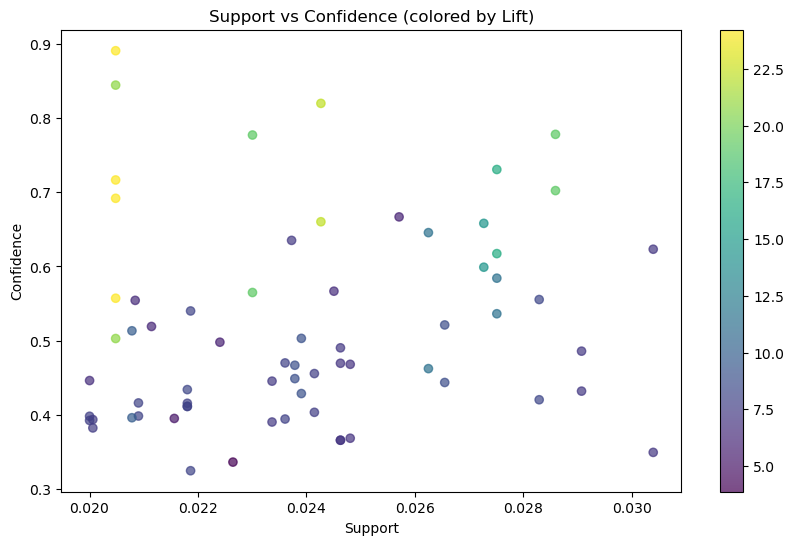

In [26]:

plt.figure(figsize=(10,6))
scatter = plt.scatter(rules['support'], rules['confidence'], 
                      c=rules['lift'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('Support vs Confidence (colored by Lift)')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()


###### Network Graph of Rules 

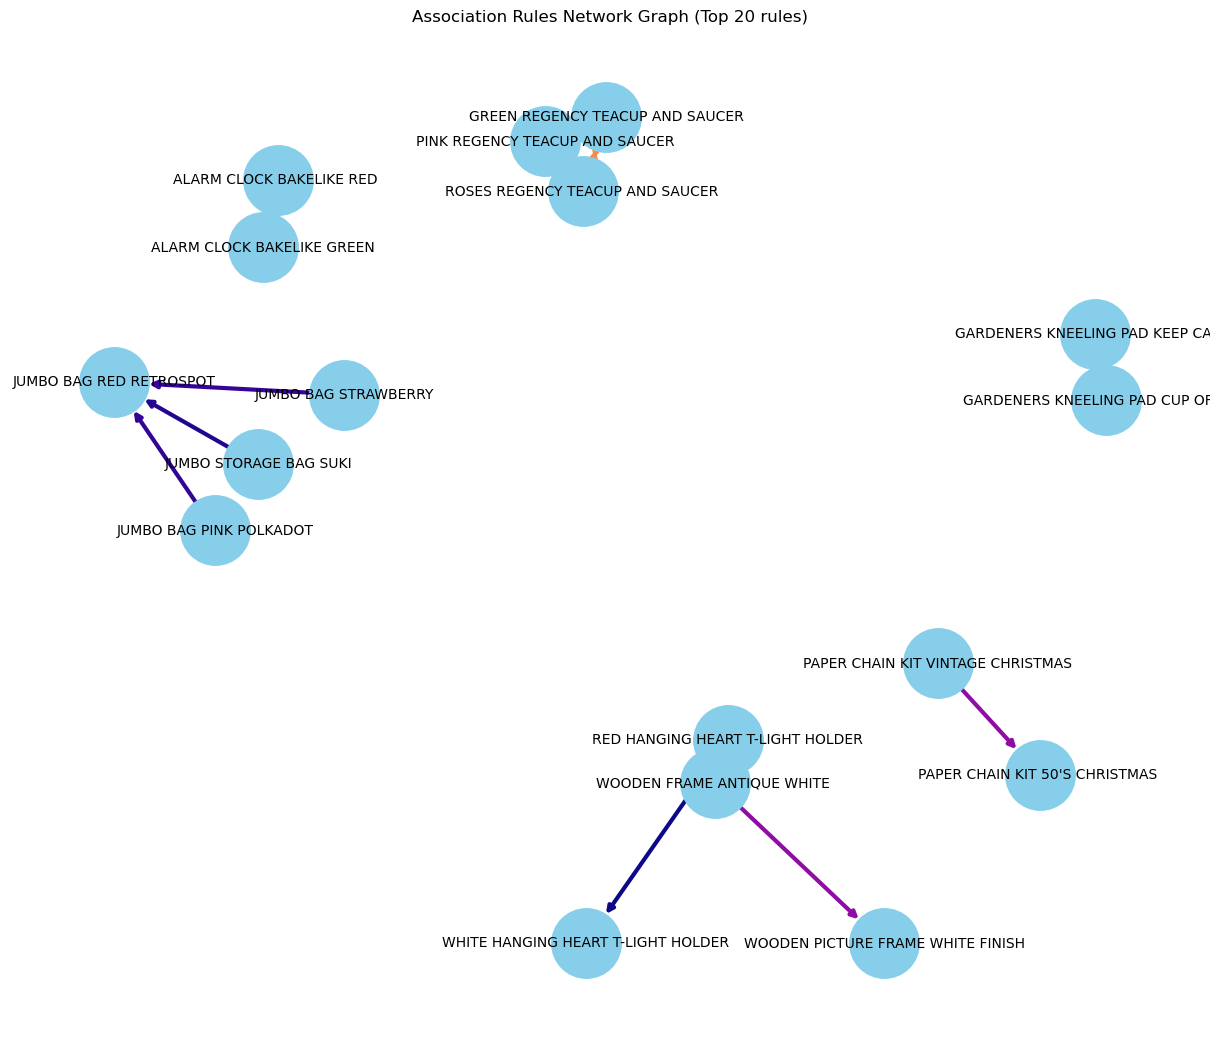

In [27]:
import networkx as nx

#Creating a directed graph
G = nx.DiGraph()

#Adding edges for top 20 rules
top_rules = rules.head(20)

for _, row in top_rules.iterrows():
    for antecedent in row['antecedents']:
        for consequent in row['consequents']:
            G.add_edge(antecedent, consequent, weight=row['lift'])

plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, k=1)
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]

nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=weights, 
        width=3, edge_cmap=plt.cm.plasma, node_size=2500, font_size=10)
plt.title('Association Rules Network Graph (Top 20 rules)')
plt.show()


###### Filtering Rules for Specific Products or Thresholds
* Filtering rules where “WHITE HANGING HEART T-LIGHT HOLDER” appears in antecedents or consequents with confidence > 0.6 and lift > 3

In [28]:
product = 'WHITE HANGING HEART T-LIGHT HOLDER'

filtered_rules = rules[(rules['confidence'] > 0.6) & (rules['lift'] > 3) & 
                       (rules['antecedents'].apply(lambda x: product in x) | 
                        rules['consequents'].apply(lambda x: product in x))]

print(filtered_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])


                           antecedents                           consequents  \
18  (RED HANGING HEART T-LIGHT HOLDER)  (WHITE HANGING HEART T-LIGHT HOLDER)   

     support  confidence      lift  
18  0.025707    0.666667  5.891366  


###### Business Insights
* Placement: Products with high lift and confidence should be placed close together to encourage cross-selling.

* Bundling: Create combo offers or discounts on frequently associated products (e.g., the different “REGENCY TEACUP AND SAUCER” variations).

* Promotions: Use association rules to design promotions targeting customers who bought one item to upsell related products.

* Inventory Planning: Stock associated products together and maintain appropriate inventory levels to avoid stockouts of related items.

In [ ]:
`